In [0]:
import pandas as pd
import io

In [4]:
from google.colab import files
uploaded = files.upload()

Saving test.txt to test.txt
Saving train.txt to train.txt


###Train and Test Data

In [0]:
f = open('train.txt','r',encoding = "utf8")
traindata = f.readlines()
traindata = [i.lower() for i in traindata]
f1 = open('test.txt','r',encoding = "utf8")
testdata = f1.readlines()
testdata = [i.lower() for i in testdata]

### Filtering Metadata

In [0]:
metaindices = []
for i in range(len(traindata)):
  if("meta\t" in traindata[i]):
    metaindices.append(i)

In [0]:
len(metaindices)

15131

In [0]:
metatestindices = []
for i in range(len(testdata)):
  if("meta\t" in testdata[i]):
    metatestindices.append(i)

In [0]:
len(metatestindices)

1869

### Tweets separation

In [0]:
testtweets = []
strng = ""
for i in range(1,len(testdata)):
  if(testdata[i] == "\n"):
    continue
  if(i not in metatestindices):
    strng = strng + testdata[i][:testdata[i].index("\t")] + " "
  else:
    strng.strip()
    testtweets.append(strng)
    strng = ""
  if(i == len(testdata)-2):
    strng.strip()
    testtweets.append(strng)
    strng = ""


In [0]:
traintweets = []
strng = ""
for i in range(1,len(traindata)):
  if(traindata[i] == "\n"):
    continue
  if(i not in metaindices):
    strng = strng + traindata[i][:traindata[i].index("\t")] + " "
  else:
    strng.strip()
    traintweets.append(strng)
    strng = ""
  if(i == len(traindata)-2):
    strng.strip()
    traintweets.append(strng)
    strng = ""

In [0]:
len(traintweets)

15131

In [0]:
len(testtweets)

1869

In [0]:
len(traindata)

426280

### Vocabulary size

In [0]:
d = {}
index=0
max_length=0
for i in traintweets:
  max_length = max(max_length, len(i.split(' ')))
  for j in i.split(' '):
    if j not in d:
      d[j] = index
      index+=1
# for i in testtweets:
#   max_length = max(max_length, len(i.split(' ')))
#   for j in i.split(' '):
#     if j not in d:
#       d[j] = index
      #index+=1

In [0]:
import numpy as np
!pip install tqdm
from tqdm import tqdm

In [0]:
# train_embedding = np.zeros((len(traintweets), len(d)))
# test_embedding = np.zeros((len(testtweets), len(d)))

# for cnt, i in enumerate(traintweets):
#   for j in i.split(' '):
#     train_embedding[cnt, d[j]] = 1
  
# for cnt, i in enumerate(testtweets):
#   for j in i.split(' '):
#     if j in d:
#       test_embedding[cnt, d[j]] = 1

In [0]:
#len(d)

In [0]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [0]:
# tokenizer_obj = Tokenizer()
# total_tweets = traintweets+testtweets
# tokenizer_obj.fit_on_texts(total_tweets)
# train_tokens = tokenizer_obj.texts_to_sequences(traintweets)
# test_tokens = tokenizer_obj.texts_to_sequences(testtweets)
# trainpad = pad_sequences(train_tokens,maxlen = max_length, padding = "post")
# testpad = pad_sequences(test_tokens,maxlen = max_length, padding = "post")

In [0]:
from keras.layers import *
from keras.models import *
from keras.utils import to_categorical

Using TensorFlow backend.


### Train_y and Test_y generation

In [0]:
labels = []
for i in metaindices:
  label = traindata[i].split("\t")[-1][:-1]
  if label=='positive':
    labels.append(0)
  elif label=='negative':
    labels.append(1)
  else:
    labels.append(2)

train_y = to_categorical(labels, num_classes=3)


In [0]:
labels = []
for i in metatestindices:
  label = testdata[i].split("\t")[-1][:-1]
  if label=='positive':
    labels.append(0)
  elif label=='negative':
    labels.append(1)
  else:
    labels.append(2)
test_y = to_categorical(labels, num_classes=3)


In [0]:
train_y.shape,test_y.shape

((15131, 3), (1869, 3))

In [0]:
#[traindata[i].split("\t")[-1][:-1] for i in metaindices]

### TfIdf Vectorization

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(traintweets+testtweets)

In [0]:
train_embedding = vectorizer.transform(traintweets)
test_embedding = vectorizer.transform(testtweets)

In [0]:
train_embedding = train_embedding.toarray()
test_embedding = test_embedding.toarray()

### Dimensional Reduction

In [0]:

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_recall_fscore_support

In [0]:
reducer = TruncatedSVD(n_components=200)
train_embedding_ = reducer.fit_transform(train_embedding)

In [0]:
test_embedding_ = reducer.transform(test_embedding)

In [0]:
train_embedding_.shape,test_embedding_.shape

((15131, 200), (1869, 200))

### Deep Neural Network

In [0]:
from keras.callbacks import *

In [0]:
model = Sequential()
model.add(Dense(64, input_shape=(train_embedding.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(3,activation='softmax'))
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [97]:
np.argmax(train_y,axis=1)

array([1, 1, 0, ..., 1, 1, 1])

In [98]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 64)                3507264   
_________________________________________________________________
activation_8 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 51        
Total params: 3,508,355
Trainable params: 3,508,355
Non-trainable params: 0
____________________________________________

In [103]:
model.fit(train_embedding, train_y, batch_size=1024,epochs=200,validation_data=(test_embedding, test_y),callbacks=callbacks_list)

Train on 15131 samples, validate on 1869 samples
Epoch 1/200
15131/15131 [==============================] - 4s 285us/step - loss: 0.4252 - acc: 0.9036 - val_loss: 0.9388 - val_acc: 0.5554

Epoch 00001: val_acc did not improve from 0.56073
Epoch 2/200
15131/15131 [==============================] - 4s 278us/step - loss: 0.3439 - acc: 0.9270 - val_loss: 0.9635 - val_acc: 0.5495

Epoch 00002: val_acc did not improve from 0.56073
Epoch 3/200
15131/15131 [==============================] - 4s 278us/step - loss: 0.2677 - acc: 0.9492 - val_loss: 0.9970 - val_acc: 0.5425

Epoch 00003: val_acc did not improve from 0.56073
Epoch 4/200
15131/15131 [==============================] - 4s 279us/step - loss: 0.2094 - acc: 0.9609 - val_loss: 1.0329 - val_acc: 0.5399

Epoch 00004: val_acc did not improve from 0.56073
Epoch 5/200
15131/15131 [==============================] - 4s 277us/step - loss: 0.1654 - acc: 0.9718 - val_loss: 1.0779 - val_acc: 0.5361

Epoch 00005: val_acc did not improve from 0.56073
E

KeyboardInterrupt: ignored

In [0]:
model.load_weights(filepath)

In [102]:
test_predictions = model.predict(test_embedding)
precision_recall_fscore_support(np.argmax(test_y,axis = 1),np.argmax(test_predictions,axis = 1),average='macro')

(0.5665106569867407, 0.5621714780411771, 0.5641001471644823, None)

In [0]:
model = Sequential()
model.add(Dense(64, input_shape=(train_embedding_.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(3,activation='softmax'))
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [105]:
model.fit(train_embedding_, train_y, batch_size=1024,epochs=200,validation_data=(test_embedding_, test_y),callbacks=callbacks_list)

Train on 15131 samples, validate on 1869 samples
Epoch 1/200
15131/15131 [==============================] - 1s 49us/step - loss: 1.0956 - acc: 0.3641 - val_loss: 1.0883 - val_acc: 0.4045

Epoch 00001: val_acc improved from -inf to 0.40449, saving model to weights.hdf5
Epoch 2/200
15131/15131 [==============================] - 0s 6us/step - loss: 1.0865 - acc: 0.3759 - val_loss: 1.0788 - val_acc: 0.4066

Epoch 00002: val_acc improved from 0.40449 to 0.40663, saving model to weights.hdf5
Epoch 3/200
15131/15131 [==============================] - 0s 6us/step - loss: 1.0746 - acc: 0.4038 - val_loss: 1.0674 - val_acc: 0.4468

Epoch 00003: val_acc improved from 0.40663 to 0.44676, saving model to weights.hdf5
Epoch 4/200
15131/15131 [==============================] - 0s 6us/step - loss: 1.0560 - acc: 0.4595 - val_loss: 1.0493 - val_acc: 0.4799

Epoch 00004: val_acc improved from 0.44676 to 0.47994, saving model to weights.hdf5
Epoch 5/200
15131/15131 [==============================] - 0s 6us

In [0]:
model.load_weights(filepath)

In [108]:
test_predictions = model.predict(test_embedding_)
precision_recall_fscore_support(np.argmax(test_y,axis = 1),np.argmax(test_predictions,axis = 1),average='macro')

(0.5685955675362454, 0.5431607887409783, 0.5503236012706578, None)

In [0]:
from sklearn.neighbors import *

### Gaussian Bayes Classifier

In [0]:
from sklearn.naive_bayes import GaussianNB


In [0]:
# trainpad = trainpad.reshape((-1,57))
# testpad = testpad.reshape((-1,57))

In [0]:
model = GaussianNB()
model.fit(train_embedding_, np.argmax(train_y,axis=1) )

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
test_predictions = model.predict(test_embedding_)

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
accuracy_score(np.argmax(test_y,axis=1), test_predictions)

0.5034777956126271

In [0]:
precision_recall_fscore_support(np.argmax(test_y,axis = 1),test_predictions,average='macro')

(0.5125972811399809, 0.5018031028843198, 0.5015689418840493, None)

### K-Nearest Neighbors Classifier

In [0]:
model = KNeighborsClassifier(n_neighbors=41)
model.fit(train_embedding_, np.argmax(train_y,axis=1))
test_predictions = model.predict(test_embedding_)
accuracy_score(np.argmax(test_y,axis=1), test_predictions)

0.48421615837346177

In [0]:
precision_recall_fscore_support(np.argmax(test_y,axis = 1),test_predictions,average='macro')

(0.5306511271845491, 0.44973814582686283, 0.4443692614133994, None)

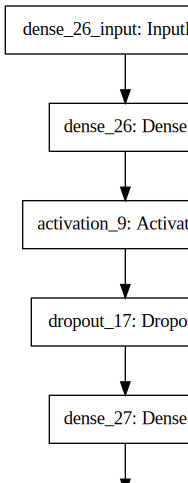

In [109]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

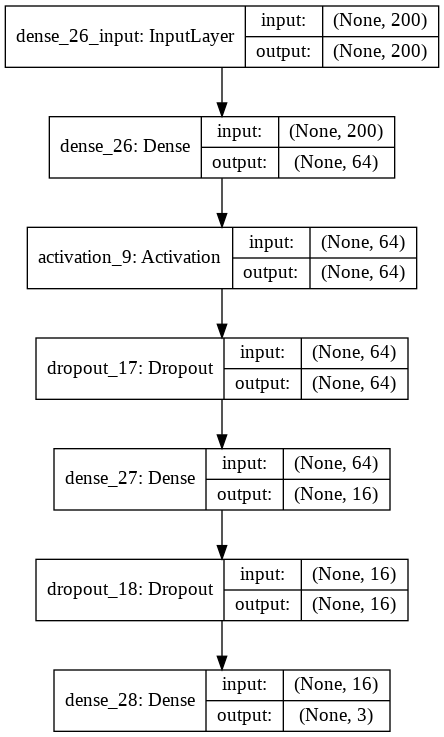

In [110]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)